In [2]:
from Saving import *
from preprocessing import *
import pandas as pd
import dateparser
import datetime
import time
from dateutil import parser

... OK (Got response in 0.45 seconds)
Writing emoji data to /Users/salkhalil/.demoji/codes.json ...
... OK


In [3]:
hourly_embs = openPk('hourly_embs.pkl')
t_vecs = openPk('topNg_vecs.pkl')
full_corpus = openDf('full_corpus')

In [6]:
top_results   = openPk('top_results.pkl')
topNg_results = openPk('topNg_results.pkl')

In [55]:
saveDf('full_corpus.csv', full_corpus)

In [7]:
full_corpus.loc[(full_corpus.top_Ng == -1) & (full_corpus.top_g != -1)]

,authorName,createdAt,Comp,message,URLs,msg_clean,t2v,top_Ng,top_g,deviation
1,Drmicrocap,2017-08-02 09:01:54,aapl,https://drmicrocap.blogspot.com/2017/08/apple-...,https://drmicrocap.blogspot.com/2017/08/apple-...,http drmicrocap blogspot com apple repor...,#aapl #Nasdaq Composite #S& Index #Dow Jones,-1,105,0.000000
19,tony,2019-08-26 23:50:26,aapl,The G7 represents 7 democratic countries. Why ...,NaN,the represents democratic country why doe ...,The represents democratic countries. Why doe...,-1,53,0.000000
20,John,2019-10-25 09:42:57,aapl,Does FAANG still exist or is it now dead after...,NaN,does faang still exist or is it now dead after...,Does FAANG still exist or is it now dead after...,-1,47,0.000000
22,Jim Lahey,2020-01-03 16:07:33,aapl,The dip today is just getting started followed...,NaN,the dip today is just getting started followed...,The dip today is just getting started followed...,-1,16,0.000000
69,Bullseye,2020-09-08 20:54:59,aapl,More hurt is still to come and it's still mass...,NaN,more hurt is still to come and it s still mas...,More hurt is still to come and it's still mass...,-1,50,0.000000
...,...,...,...,...,...,...,...,...,...,...
169681,Silent Running,2020-12-14 18:28:35,pypl,"So, the march to $250 is finally underway. O...",NaN,so the march to $ is finally underway onl...,"So, the march to $ is finally underway. Only...",-1,74,0.001562
169688,Roseanna,2020-12-14 20:00:59,pypl,glad to hear that,NaN,glad to hear that,glad to hear that,-1,124,-0.197023
169690,tshart,2020-12-14 20:01:14,pypl,ill check this one,NaN,ill check this one,ill check this one,-1,124,-0.232046
169784,holly,2020-12-17 15:47:28,pypl,did any of you watched Bloomberg last night?\n...,NaN,did any of you watched bloomberg last night ...,did any of you watched Bloomberg last night? A...,-1,72,-0.121128


In [10]:
t_vecs[2].shape

(136, 2)

In [ ]:
def calc_devation(df, comp, embs, window = 4):
    our_df = df.loc[df.Comp == comp]
    inds = our_df.index.values
    last_4embs = np.zeros((4, embs.shape[1]))
    last_4devs = np.zeros(4)
    rng = range(len(inds))
    devs = []
    for i in rng:
        avg_dev = np.mean(last_4devs)
        dev = np.linalg.norm(embs[i, :] - last_4embs[(i-1)%window, :])
        last_4embs[i%window, :] = embs[i,:]
        last_4devs[i%window] = dev
        devs.append((dev-avg_dev)/(avg_dev+1))
    return devs

In [18]:
from umap import UMAP

In [19]:
def reduce_dims(embs, ndims):
    ret_dict = {}
    for nd in ndims:
        umap_embs = umap.UMAP(n_neighbors=15,
                                n_components=nd,
                                metric='cosine').fit_transform(embs)
        ret_dict[nd] = umap_embs
        
    return ret_dict

In [33]:
full_embs = openPk('full_embs.pkl')

In [3]:
from bertopic import BERTopic

In [57]:
bTopNg_model = BERTopic.load("base_hourly_noGram")
bTop_model = BERTopic.load("base_hourly_gram")

In [58]:
def calculate_top_vecs(ntops, df, embeddings, top_col = 'top_Ng'):
    emb_dim = embeddings.shape[1]
    top_vecs = np.zeros((ntops-1, emb_dim))
    for top in range(ntops-1):
        inds = df.loc[df[top_col] == top].index
        t_vec = np.zeros(emb_dim)
        for ind in inds:
            t_vec += embeddings[ind, :]
        t_vec /= len(inds)
        top_vecs[top, :] = t_vec
    return top_vecs

In [61]:
top_vecs = {}
topNg_vecs = {}
for i in [2, 5]:
    top_vecs[i]   = calculate_top_vecs(len(bTop_model.get_topics()), full_corpus, full_embs[i], top_col='top_g')
    topNg_vecs[i] = calculate_top_vecs(len(bTopNg_model.get_topics()), full_corpus, full_embs[i])

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [75]:
def plot_t_vecs(data):
    sns.scatterplot(data[:,0], data[:,1])

In [74]:
t_vec_plot = {2: top_vecs[2], 5: umap.UMAP(n_neighbors=15,
                                n_components=2,
                                metric='cosine').fit_transform(top_vecs[5])}
tNg_vec_plot = {2: topNg_vecs[2], 5: umap.UMAP(n_neighbors=15,
                                n_components=2,
                                metric='cosine').fit_transform(topNg_vecs[5])}

In [77]:
top_vecs_p = {'g': t_vec_plot, 'ng': tNg_vec_plot}

In [81]:
savePk('top_vecs4plot', top_vecs_p)

In [83]:
def dict_from_gt(gt):
    out_dict = {}
    keys = gt.keys()
    for k in keys:
        tuples = gt[k]
        out_dict[k] = [t[0] for t in tuples if t[1] > 0.001]

    return out_dict

ng_tws = dict_from_gt(bTopNg_model.get_topics())
g_tws = dict_from_gt(bTop_model.get_topics())

In [88]:
import csv

In [96]:
def write_tws(t_dict, fn):
    with open(fn, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=['Topic', 'Words'])
        writer.writeheader()
        for k in t_dict.keys():
            f.write('{}, {}\n'.format(str(k), '; '.join(t_dict[k])))
        f.close()

In [97]:
write_tws(ng_tws, 'topic_words_noGram.csv')
write_tws(g_tws, 'topic_words_wGram.csv')

In [107]:
a = full_corpus.index.values[:10]
b = full_corpus.index.values[10:]

In [111]:
len(full_embs[5])

169825

In [112]:
def dev_from_start(df, comp, embs): 
    our_df = df.loc[(df.Comp == comp) & (df.t2v != 'n')]
    inds = our_df.index.values
    nd = embs.shape[1]
    # get first average of first 10 messages for starting point
    firstInds = inds[:10]
    start_vec = np.zeros(nd)
    for i in firstInds:
        start_vec += embs[i, :]
    start_vec /= 10
    
    dists = []
    dates = []
    
    for i in inds[10:]:
        dist_vec = embs[i,:] - start_vec
        dists.append(np.linalg.norm(dist_vec))
        dates.append(df['createdAt'].iloc[i])
    
    plt.plot (dates, dists)

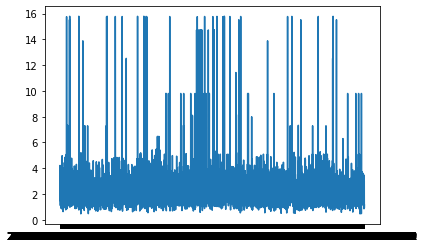

In [113]:
dev_from_start(full_corpus, 'pypl', full_embs[5])

In [121]:
full_corpus['top_Ng'].value_counts().index.values[0]

-1

In [29]:
a = np.array([1,2,4])
b = np.array([3,5,6])
c = np.zeros(3)
for i in [a, b]:
    c+= i
c /= 2    

In [30]:
c

array([2. , 3.5, 5. ])

In [127]:
def find_main_topic(df, comp, mod='top_Ng'):
    our_df = df.loc[(df.Comp == comp) & (df.t2v != 'n')]
    max_ind = our_df[mod].value_counts().index.values[0]
    
    if max_ind == -1:
        return our_df[mod].value_counts().index.values[1]
    return max_ind

In [138]:
def dev_from_main(df, comp, embs, t_vecs, mod = 'top_Ng'):
    our_df = df.loc[(df.Comp == comp) & (df.t2v != 'n')]
    main_top = find_main_topic(df, comp, mod)
    main_top_vec = t_vecs[main_top, :]
    
    nTops = t_vecs.shape[0]
    main_vec = t_vecs[main_top, :]
    dist_dict = {}
    dist_dict[-1] = 0
    for i in range(nTops):
        cur_top = t_vecs[i, :]
        similarity = np.linalg.norm(cur_top - main_vec)
        dist_dict[i] = similarity
    

    dists = our_df[mod].apply(lambda x: dist_dict[x])
    
    # getting index score
    dists_norm = [(d - min(dists))/(max(dists)-min(dists)) for d in dists]
    score = np.mean(dists_norm)
    print(score)
    plt.plot(our_df.createdAt.values, dists)

0.1142197334793642


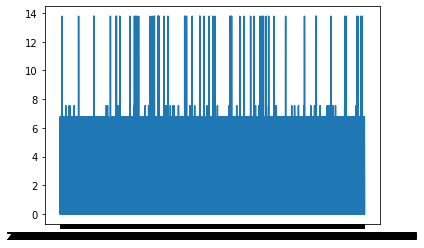

In [140]:
dev_from_main(full_corpus, 'aapl', full_embs[5], topNg_vecs[5])

In [125]:
savePk('top_vecs', top_vecs)
savePk('topNg_vecs', topNg_vecs)

In [126]:
top_vecs

{2: array([[ 7.91948166e+00, -4.05754628e+00],
        [ 7.69892265e+00, -8.41833060e+00],
        [ 4.46929266e+00,  1.53790192e+00],
        [ 1.98287055e+01,  1.15570169e+01],
        [ 1.40315326e+01,  2.28188907e+00],
        [ 8.04922645e+00, -3.94245016e+00],
        [ 4.20293887e+00, -1.53831771e+00],
        [ 2.65414241e+00, -7.12355844e+00],
        [ 1.99006722e+01,  3.33074140e+00],
        [ 1.23842280e+01,  1.74251137e+00],
        [ 1.30548903e+01,  2.06208969e+00],
        [ 1.28576495e+01, -8.82566821e-01],
        [ 1.24236302e+01, -1.22651914e+00],
        [ 1.18474442e+01, -8.81983494e-01],
        [ 9.08917516e+00,  4.10392658e+00],
        [ 9.37613625e+00,  2.65837551e+00],
        [ 1.09276587e+01, -4.24050914e-01],
        [ 9.33731504e+00,  2.57146657e+00],
        [ 8.20340169e+00,  1.43550195e+00],
        [ 7.04332804e+00, -4.06818119e-01],
        [ 7.56620026e+00,  1.21666656e+00],
        [ 8.63705063e+00,  2.94006707e+00],
        [ 1.06702719e+01,  2.

In [136]:
full_corpus.Comp.unique()

array(['aapl', 'abb', 'amzn', 'aon', 'bmy', 'cern', 'csco', 'ebay',
       'hsbc', 'jpm', 'mmm', 'nflx', 'pypl'], dtype=object)

In [32]:
if 's' in 'hello':
    print('lol')

In [119]:
def window_check(t1, t2, window):
    t1_sec, t2_sec = time.mktime(t1), time.mktime(t2)
    wind_sec = window*60**2
    if t2_sec - t1_sec < wind_sec and t2_sec - t1_sec > 0:
        return True
    return False

def get_time(df, ind, date_col='createdAt'):
    return df[date_col].iloc[ind]
def parse_dtime(time_str):
    parsed_dtime = time.strptime(str(time_str), '%Y-%m-%d %H:%M:%S')
    return parsed_dtime

In [19]:
t1 = get_time(full_corpus, 0)
t2 = get_time(full_corpus, 1)

window_check(parse_dtime(t1), parse_dtime(t2), 2)

False

In [116]:
def split_df(df, window):
    inds = df.index.values
    blocks = []
    cur_ind = 0
    while cur_ind < len(inds):
        j = 1
        cur_t = get_time(df, cur_ind)

        if cur_ind + j >= len(inds):
            blocks.append((cur_ind, cur_ind))
            break
        next_t = get_time(df, cur_ind+j)
        
        while window_check(parse_dtime(cur_t), parse_dtime(next_t), window) and cur_ind+j < len(inds):
            j += 1
            if cur_ind+j < len(inds):
                next_t = get_time(df, cur_ind+j)
        
        blocks.append((cur_ind, cur_ind+j-1))
        cur_ind += j
    return blocks

In [28]:
full_corpus.loc[full_corpus.t2v == 'n']

,authorName,createdAt,Comp,message,URLs,msg_clean,t2v,top_Ng,top_g,deviation
209,Stephen,2020-10-16 15:38:04,aapl,n,NaN,n,n,1,2,0.000000
231,John,2020-10-16 15:54:17,aapl,n,NaN,n,n,4,3,0.000000
239,Web,2020-10-16 15:59:05,aapl,n,NaN,n,n,1,2,0.000000
277,John,2020-10-16 16:33:33,aapl,n,NaN,n,n,4,3,0.000000
300,Web,2020-10-16 16:46:45,aapl,n,NaN,n,n,4,3,0.000000
...,...,...,...,...,...,...,...,...,...,...
169052,Steve,2020-11-03 21:30:46,pypl,n,NaN,n,n,4,3,3.566881
169372,Paul P,2020-11-21 00:52:13,pypl,n,NaN,n,n,4,3,5.318325
169446,Paul P,2020-11-25 21:00:11,pypl,n,NaN,n,n,1,2,4.930038
169531,Nick M,2020-12-01 14:18:53,pypl,n,NaN,n,n,4,3,5.213745


In [31]:
(np.array([i[1] - i[0] +1 for i in split_df(full_corpus, 100)])).shape

(1556,)

In [121]:
def calc_score(dists):
    dists_norm = minmax_scale(dists)
    score = np.mean(dists_norm)
    return score

def calc_block_dev(df, block, embs, t_vecs, mod = 'top_Ng'):
    block_start, block_end = block
    block_df = df.iloc[block_start:block_end+1]
    
    inds = block_df.index.values
    nd = embs.shape[1]
    main_dists = []
    start_dists = []
    block_size = len(inds)
    if block_size == 1:
        main_dists.append(0)
        start_dists.append(0)
        return 1, 1
    else:
        start_bs = block_size // 10
        if start_bs == 0:
            start_bs = 1
        first_inds = inds[:start_bs]
        start_vec = np.zeros(nd)
        for i in first_inds:
            start_vec += embs[i, :]
        start_vec /= start_bs
        
        for i in inds[start_bs:]:
            dist_vec = embs[i,:] - start_vec
            start_dists.append(np.linalg.norm(dist_vec))
        
        tops = block_df[mod].value_counts().index.values
        main_top = tops[0]
        if main_top == -1:
            if len(tops) > 1:
                main_top = tops[1]
            else: 
                main_dists = [0]
                dfm = calc_score(main_dists)
                dfs = calc_score(start_dists)
                return dfs, dfm
    
        main_t_vec = t_vecs[main_top, :]
        nTops = t_vecs.shape[0]
        dist_dict = {}
        dist_dict[-1] = 0
        for i in range(nTops):
            cur_top = t_vecs[i, :]
            sim = np.linalg.norm(cur_top - main_t_vec)
            dist_dict[i] = sim
        main_dists = block_df[mod].apply(lambda x: dist_dict[x])
        main_dists = main_dists.values
        
        dfm = calc_score(main_dists)
        dfs = calc_score(start_dists)
        return dfs, dfm
    
    
def calc_per_block(df, window, embs, t_vecs, mod = 'top_Ng'):
    our_df = df.loc[df.t2v != 'n']
    blocks = split_df(our_df, window)
    dfs_scores, dfm_scores = [], []
    for b in blocks:
        dfs, dfm = calc_block_dev(df, b, embs, t_vecs)
        dfs_scores.append(dfs)
        dfm_scores.append(dfm)
    plt.plot([*range(len(dfs_scores))], dfs_scores)
    plt.plot([*range(len(dfm_scores))], dfm_scores)
    plt.legend(['Dev from Start', 'Dev from Main'])

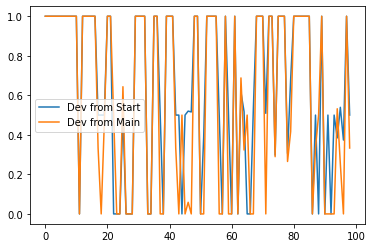

In [122]:
calc_per_block(full_corpus.loc[full_corpus.Comp == 'abb'], 100, full_embs[5], t_vecs[5])

In [63]:
from sklearn.preprocessing import minmax_scale, MinMaxScaler

In [65]:
minmax_scale([10])

array([0.])

In [74]:
full_corpus.Comp.unique()

array(['aapl', 'abb', 'amzn', 'aon', 'bmy', 'cern', 'csco', 'ebay',
       'hsbc', 'jpm', 'mmm', 'nflx', 'pypl'], dtype=object)

In [136]:
full_corpus.loc[full_corpus.Comp == 'abb']

,authorName,createdAt,Comp,message,URLs,msg_clean,t2v,top_Ng,top_g,deviation
37860,RogerDurk,2016-07-21 10:07:36,abb,"there's always this, fwiw http://www.investor...",http://www.investorvillage.com/smbd.asp?mb=251,there s always this fwiw http mb,"there's always this, fwiw",135,-1,0.0
37861,David,2016-08-10 17:13:26,abb,Revised for mat is not good!,NaN,revised for mat is not good,Revised for mat is not good!,80,-1,0.0
37862,elie,2016-10-13 19:19:56,abb,guys how can it be that abb have not interest...,NaN,guy how can it be that abb have not interest e...,guys how can it be that abb have not interest...,-1,11,0.0
37863,Nick_In_Message,2017-01-15 21:49:46,abb,Are Dividends of ABB reduced by 35% because of...,NaN,are dividends of abb reduced by because of ...,Are Dividends of ABB reduced by % because of S...,-1,-1,0.0
37864,David N,2017-02-23 17:42:27,abb,"So, an employee walks out from tha ABB Korean ...",NaN,so an employee walk out from tha abb korean ...,"So, an employee walks out from tha ABB Korean ...",-1,-1,0.0
...,...,...,...,...,...,...,...,...,...,...
38071,Oran,2020-12-10 13:39:51,abb,hope people confuse this with abnb,NaN,hope people confuse this with abnb,hope people confuse this with abnb,12,11,0.0
38072,Enginer,2020-12-12 04:17:27,abb,Recently saw that Volvo (w/ABB) had 145 articu...,NaN,recently saw that volvo w abb had articul...,Recently saw that Volvo (w/ABB) had articulat...,-1,47,0.0
38073,Anonymous,2020-12-16 11:26:10,abb,https://www.afcenergy.com/afc-energy-and-abb-p...,https://www.afcenergy.com/afc-energy-and-abb-p...,http,NaN,1,2,0.0
38074,Satz,2020-12-16 16:54:00,abb,Buy Afc they will boom ..abb made a contract f...,NaN,buy afc they will boom abb made a contract ...,Buy Afc they will boom ..abb made a contract f...,-1,-1,0.0


In [134]:
def check_split(blocks, thresh):
    block_dif = [b[1] - b[0] for b in blocks]
    sing_bc = 0
    for d in block_dif:
        if d == 1:
            sing_bc += 1
    if (sing_bc / len(block_dif)) < thresh:
        return True
    return False

def split_df_auto(df, thresh, precision=5):
        wind = 1
        while True:
            blocks = split_df(df, wind)
            if check_split(blocks, thresh):
                return blocks, wind
            wind += precision

In [135]:
b, s = split_df_auto(full_corpus.loc[full_corpus.Comp == 'pypl'], 0.01)
print(len(b), s)

134 76


In [137]:
full_corpus[['createdAt', 'top_Ng']].values

array([['2017-04-21 14:56:59', -1],
       ['2017-08-02 09:01:54', -1],
       ['2017-11-01 06:10:40', -1],
       ...,
       ['2020-12-20 22:40:10', 80],
       ['2020-12-21 00:06:01', -1],
       ['2020-12-21 01:26:42', 16]], dtype=object)

In [26]:
def parse_dtime(time_str):
    parsed_dtime = time.strptime(str(time_str), '%Y-%m-%d %H:%M:%S')
    return parsed_dtime

def midpoint_times(t1, t2):
    new1 = parse_dtime(t1); new2 = parse_dtime(t2)

    mp = (time.mktime(new2) + time.mktime(new1)) / 2
    
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(mp))

In [27]:
t1 = full_corpus.createdAt.iloc[2]; t2 = full_corpus.createdAt.iloc[5]
midpoint_times(t1, t2)

'2018-02-04 00:35:38'